<a href="https://colab.research.google.com/github/cardosorrenan/research-project/blob/main/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Install and import packages**

In [ ]:
!pip install -U tensorly ecg-plot iteration_utilities 

import os
import tarfile
import timeit
import random
import math
import itertools

from google.colab import drive
from operator import itemgetter
from scipy.io import loadmat
from tensorly import tensor, norm
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2, l1_l2

import numpy as np
import pandas as pd
import tensorly as tl
import ecg_plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 198 kB 7.3 MB/s 
     |████████████████████████████████| 283 kB 53.6 MB/s 
     |████████████████████████████████| 154 kB 76.5 MB/s 


### **Functions**

In [ ]:
def import_databases(databases):
  headers = list()
  recordings = list()
  for db in databases:
    if not os.path.exists(db):
      path = path_folder + db + '.tar.gz'
      with tarfile.open(path) as zip_file:
        zip_file.extractall()
    headers_db, recordings_db = find_database_files(db)
    headers.append(headers_db)
    recordings.append(headers_db)
  return list(itertools.chain(*headers)), list(itertools.chain(*recordings))


def find_database_files(data_directory):
  headers_db = list()
  recordings_db = list()
  for f in sorted(os.listdir(data_directory)):
    root, extension = os.path.splitext(f)
    if not root.startswith('.') and extension=='.hea':
      header_db_file = os.path.join(data_directory, root + '.hea')
      recording_db_file = os.path.join(data_directory, root + '.mat')
      if os.path.isfile(header_db_file) and os.path.isfile(recording_db_file):
        headers_db.append(header_db_file)
        recordings_db.append(recording_db_file)
  print(f'Found {len(recordings_db)} recordings in {data_directory}.')
  return headers_db, recordings_db


def get_leads(header):
  leads = list()
  for i, l in enumerate(header.split('\n')):
    entries = l.split(' ')
    if i==0:
      num_leads = int(entries[1])
    elif i<=num_leads:
      leads.append(entries[-1])
    else:
      break
  return tuple(leads)


def choose_leads(recording, header, leads):
  num_leads = len(leads)
  num_samples = np.shape(recording)[1]
  chosen_recording = np.zeros((num_leads, num_samples), recording.dtype)
  available_leads = get_leads(header)
  for i, lead in enumerate(leads):
    if lead in available_leads:
      j = available_leads.index(lead)
      chosen_recording[i, :] = recording[j, :]
  return chosen_recording


# Get recording ID.
def get_recording_id(header):
    recording_id = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                recording_id = l.split(' ')[0]
            except:
                pass
        else:
            break
    return recording_id

  
def load_header(header_file):
  with open(header_file, 'r') as f:
    header = f.read()
  return header


def load_recordings(header_filenames, leads, seconds):
  recordings = list()
  for header_file in header_filenames:
    header = load_header(header_file)
    rec_file = header_file.replace('hea', 'mat')
    recording = loadmat(rec_file)['val']
    recording = choose_leads(recording, header, leads)
    # id = str(generate_id())[0:6] + get_recording_id(header)
    # print(id)
    recordings.append(recording)
  frequency = get_frequency(load_header(header_filenames[0]))
  interval = int(seconds * frequency)
  recordings = random_cut_intervals(recordings, interval)
  recordings = np.array(recordings)
  print(recordings.shape)
  plot_ecg(recordings[0], frequency)
  return recordings


def is_integer(x):
  if is_number(x):
    return float(x).is_integer()
  else:
    return False


def is_number(x):
  try:
    float(x)
    return True
  except (ValueError, TypeError):
    return False


def random_cut_intervals(recordings, size_interval):
  rec_cuts = list()
  for rec in recordings:
    size_rec = rec.shape[1]
    samples_rec = math.floor(size_rec/size_interval)
    for i in range(0, samples_rec):
      inf = i*size_interval
      sup = ((i+1)*size_interval)
      rec_interval = np.array(list(map(lambda lead: lead[inf:sup], rec)))
      rec_cuts.append(rec_interval)
  random.shuffle(rec_cuts)
  print(f'Unattached {len(rec_cuts)} intervals with {size_interval} entries.')
  return rec_cuts


def get_labels(header):
  labels = list()
  for l in header.split('\n'):
    if l.startswith('#Dx'):
      try:
        entries = l.split(': ')[1].split(',')
        for entry in entries:
          labels.append(entry.strip())
      except:
        pass
  return labels


def get_frequency(header):
    frequency = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                frequency = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    return frequency


def get_classes(headers):
  classes = set()
  for header_file in headers:
    header = load_header(header_file)
    classes |= set(get_labels(header))
  if all(is_integer(x) for x in classes):
    classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
  else:
    classes = sorted(classes) # Sort classes alphanumerically if not numbers.
  return classes


def filter_header_class(headers, class_record):
  name, code = itemgetter('name', 'code')(class_record)
  filtered_headers = list()
  for header_file in headers:
    header = load_header(header_file)
    labels = get_labels(header)
    if code in labels:
      filtered_headers.append(header_file)
  num_filtered_headers = len(filtered_headers)
  print(f'Found {num_filtered_headers} recordings for {name}.')
  return filtered_headers


def plotting_rec_lengths(header_filenames):
  recordings, _ = load_recordings(header_filenames)
  recordings_sizes = list(map(lambda rec: rec.shape[1], recordings))
  sns.set(rc={'figure.figsize':(20,5)})
  sns.scatterplot(x=np.arange(len(recordings_sizes)), y=recordings_sizes)


def plot_ecg(record, rate):
  ecg_plot.plot(record/1000, sample_rate=rate, title='')
  ecg_plot.show()

### **Get header and recordings filenames**

In [ ]:
drive.mount('/content/gdrive')
path_folder = '/content/gdrive/MyDrive/Pesquisa Mestrado/Parte II (Novembro-)/Databases/PhysioNet-CinC21/'
available_databases = ['WFDB_CPSC2018', 
                       'WFDB_CPSC2018_2', 
                       'WFDB_StPetersburg', 
                       'WFDB_PTB', 
                       'WFDB_PTBXL',
                       'WFDB_Ningbo',
                       'WFDB_Ga',
                       'WFDB_ChapmanShaoxing']
dbs = available_databases[0:1]
headers, recordings = import_databases(dbs)

Mounted at /content/gdrive
Found 6877 recordings in WFDB_CPSC2018.


### **Configs to extract data**

In [ ]:
classes = { 'AF': { 'code': '164889003', 'name': 'Atrial Fibrilation' }, 
            'SR': { 'code': '426783006', 'name': 'Sinus Rhythm' }}
leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')
seconds = 1

### **Extracts by class, leads and time**

Found 1221 recordings for Atrial Fibrilation.
Unattached 18306 intervals with 500 entries.
(18306, 12, 500)


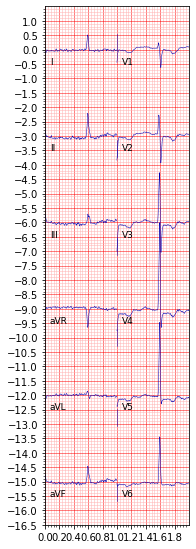

Found 918 recordings for Sinus Rhythm.
Unattached 14116 intervals with 500 entries.
(14116, 12, 500)


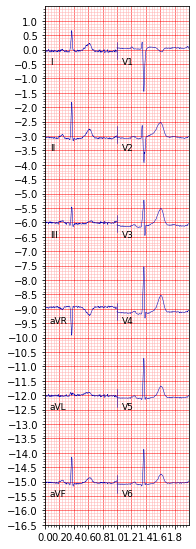

In [ ]:
headers_AF = filter_header_class(headers, classes['AF'])
recordings_AF = load_recordings(headers_AF, leads, seconds)

headers_SR = filter_header_class(headers, classes['SR'])
recordings_SR = load_recordings(headers_SR, leads, seconds)

In [ ]:
recordings_AF[0].shape

(12, 500)

# **Tensor Approach**

### **Functions**

In [ ]:
def pci(T, R, rank, max_iter=1000, min_decrease=1e-5):
  shape = np.array(T).shape
  dim = range(len(rank))
  tensors = [tensor(np.zeros(shape)) for r in range(R)]
  last = 1
  for i in range(max_iter):
    btd = []  
    print(f"[Iter {i+1}]")
    for r in range(R):
      Tres = T - (sum(tensors) - tensors[r])
      print(f"     HOOI {r+1}", end="")
      Td = tucker(tensor=Tres, rank=rank, n_iter_max=max_iter, init='svd', svd='numpy_svd', tol=min_decrease)
      btd.append(Td)
      Tapprox = tucker_to_tensor(Td)
      print(f"     Norm {norm(Tapprox)}")
      tensors[r] = Tapprox
    Tres = T - sum(tensors)
    error = norm(Tres)/norm(T)
    decrease = last - error
    print("    -----------------------------")
    print(f"    Error {error}")
    print(f"    Decrease {decrease}\n")
    if decrease <= min_decrease:
      break
    last = error
  return btd, tensors


def BTD(T, R, m_rank):
  start = timeit.default_timer()
  terms, _ = pci(T, R, m_rank)
  stop = timeit.default_timer()
  execution_time = str(stop - start)
  print(f"Program Executed in {execution_time}")
  return terms

### **Decomposing BTD**

Unattached 2 intervals with 2500 entries.
(2, 12, 2500)


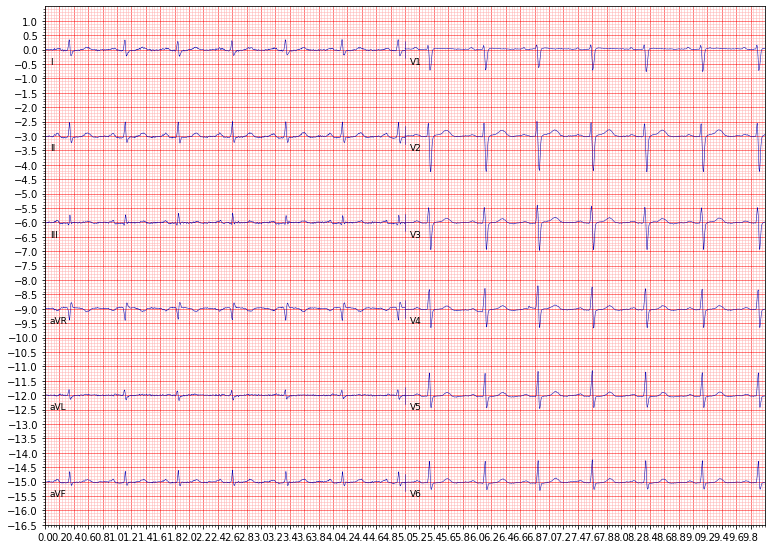

In [ ]:
recordings_AF = load_recordings(headers_SR[0:1], leads, 5)

In [ ]:
recording = recordings_AF[0]

tensor_AF = tensor(np.array(recordings_AF[0:5]))
print(tensor_AF.shape)
R = 5
m_rank = [500, 500, 12]
terms = BTD(tensor_AF, R, m_rank)

(5, 12, 500)
[Iter 1]
     HOOI 1     Norm 43013.496630682836
     HOOI 2     Norm 4949.938936594781
     HOOI 3     Norm 1272.596326735879
     HOOI 4     Norm 158.98344914672924
     HOOI 5     Norm 24.412666688957838
    -----------------------------
    Error 3.0300496861069356e-15
    Decrease 0.999999999999997

[Iter 2]
     HOOI 1     Norm 43013.49663068281
     HOOI 2     Norm 4949.938936594776
     HOOI 3     Norm 1272.5963267358802
     HOOI 4     Norm 158.983449146729
     HOOI 5     Norm 24.412666688957867
    -----------------------------
    Error 6.209620759506622e-15
    Decrease -3.1795710733996863e-15

Program Executed in 7.388867808999748


### **View results**

In [ ]:
print('TD [1]')
print()
print(terms[0][0].shape)
print(terms[0][1][0].shape)
print(terms[0][1][1].shape)
print(terms[0][1][2].shape)
print()
print('...')
print()
print('TD [5]')
print()
print(terms[4][0].shape)
print(terms[4][1][0].shape)
print(terms[4][1][1].shape)
print(terms[4][1][2].shape)

TD [1]

(5, 12, 12)
(5, 5)
(12, 12)
(500, 12)

...

TD [5]

(5, 12, 12)
(5, 5)
(12, 12)
(500, 12)


# **Convolutional Neural Network**

### **Functions**

In [ ]:
def cnn_1(input_shape):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(1, 4), strides=3, input_shape=input_shape))
  model.add(Activation(relu))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
  model.add(Conv2D(32, kernel_size=(1, 8), strides=3))
  model.add(Activation(relu))
  model.add(MaxPooling2D(pool_size=(1, 10), strides=3))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(50, activation='linear'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.summary()
  return model


# https://github.com/mbarzegary/ecg-classification-keras-cnn/blob/master/train_keras.py
def cnn_2(input_shape):
  model = Sequential()
  model.add(Conv2D(64, (4, 4), input_shape=input_shape, padding='same', kernel_regularizer=l1_l2(0.0001, 0.0001), activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
  model.add(MaxPooling2D((4, 4)))
  model.add(Dropout(0.20))
  model.add(Conv2D(256, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
  model.add(Conv2D(256, (4, 4), kernel_regularizer=l2(0.0001), padding='same', activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.20))
  model.add(Flatten())
  model.add(Dense(256, kernel_regularizer=l2(0.0001), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  model.summary()
  return model


def build_model(model, epochs, batch_size, train_x, test_x, train_y, test_y):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  callbacks_list = [
      keras.callbacks.ModelCheckpoint(
          filepath='model.h5',
          monitor='val_loss', save_best_only=True, verbose=1),
      keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
  ]

  return model.fit(X_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   callbacks = callbacks_list,
                   verbose=1,
                   validation_data=(X_test, y_test))


def plot_results(model):  
  fig, ax = plt.subplots(1,2, figsize=(16,8))
  ax[0].plot(model.history['loss'], color='b', label="Training loss")
  ax[0].plot(model.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(model.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(model.history['val_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

### **Preparing Data**

In [ ]:
X = np.vstack((recordings_AF, recordings_SR))
y = np.hstack((np.ones(len(recordings_AF)).T, np.zeros(len(recordings_SR)).T))
y = keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.reshape([*X_train.shape[0:3], 1])
X_test = X_test.reshape([*X_test.shape[0:3], 1])

### **Classifier**

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 12, 500, 64)       1088      
                                                                 
 batch_normalization (BatchN  (None, 12, 500, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 500, 64)       65600     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 3, 125, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 3, 125, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 125, 256)      

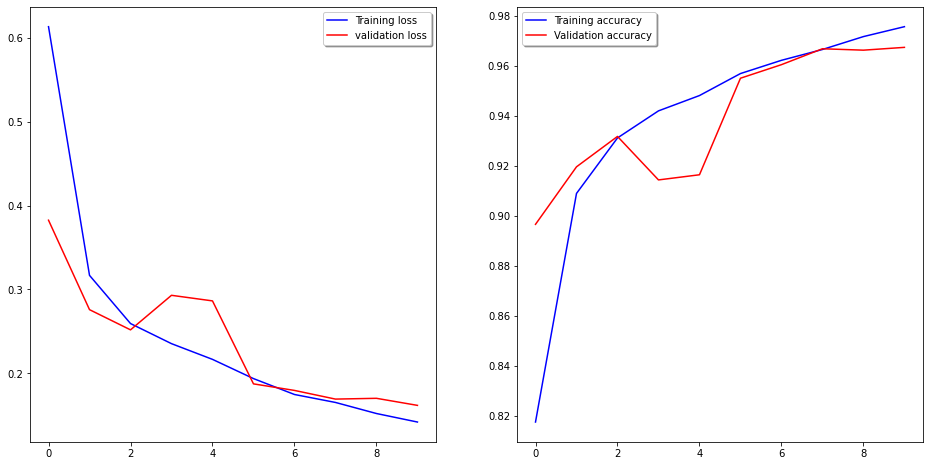

In [ ]:
net = cnn_2(X_train.shape[1:])
# net = cnn_2()
batch_size = 124
epochs = 10
model = build_model(net, epochs, batch_size, X_train, y_train, X_test, y_test)
plot_results(model)

### **Load Model**

Model1 - 09-01
 - WFDB_CPSC2018
 - Train (21722, 12, 500)
 - Test (10700, 12, 500)
 - CNN_2
 - Epochs 10, Batch Size 124
 - ~ 10h

In [ ]:
loaded_model = load_model('/content/gdrive/MyDrive/Pesquisa Mestrado/Parte II (Novembro-)/Databases/Models/Model1.h5')
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 97.94%
